# split des commentaires en phrases
- plusieurs thèmes/topics possibles par commentaires
- séquences moins longues et plus faciles à comparer

In [16]:
import data_loader

dataset = data_loader.Data(sample_size=10000)

# embedding du corpus

In [27]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('distilbert-multilingual-nli-stsb-quora-ranking')
#model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

corpus_embeddings = model.encode(dataset.sentences_df['sentence'].to_numpy(), convert_to_tensor=True)

In [28]:
# TODO save/read to local file

# semantic search

In [29]:
def search(queries, top_k=10):
    queries_embeddings = model.encode(queries, convert_to_tensor=True)
    results = util.semantic_search(queries_embeddings, corpus_embeddings, top_k=top_k)
    for q, query_results in enumerate(results):
        print(queries) if isinstance(queries, str) else print(queries[q])
        print('--------------')
        for result in query_results:
            idx = result['corpus_id']
            score = round(result['score'],4)
            print(score, ' | ',dataset.sentences_df['sentence'].iloc[idx])
        print('\n')
        

In [30]:
search(['problème de livraison', "article arrivé cassé"], top_k=20)

problème de livraison
--------------
0.9924  |  Problèmes de livraison.
0.9921  |  Énormes problèmes de livraison .
0.9914  |  Problème sur la livraison.
0.9863  |  Invoquant des problèmes de livraisons.
0.9847  |  Trop de problème de livraison.
0.9838  |  plusieurs problèmes de livraison..
0.9642  |  Plus de problèmes de livraison.
0.9642  |  Incompétent  pour la livraison.
0.9631  |  De plus, j'ai également des problèmes avec la livraison.
0.9598  |  Problème avec une livraison de colis .
0.9584  |  Leur service n'est pas fiable, et je peux vous dire que quand on est professionnel et qu'on doit planifier les livraisons, cela est extrêmement préoccupant.
0.9568  |  Cdiscount  a un probleme avec ses livraisons.
0.9565  |  Service de livraison déplorable.
0.9535  |  je suis obligé de recommander l'article : problème de gestion Treés désagréableretarde la livraison
0.9531  |  frais de gestion imprévus
0.9505  |  Le service de livraison est quant à lui déplorable.
0.9491  |  J'ai eu de no

In [31]:
# let's try framing the query to be more "symetric" as MSMARCO type of models (Q&A) not available in French
queries=[
    "Aujourd’hui rebelote, livraison effectuée dans la boîte aux lettres sans même sonner.",
    "Cet appareil n’a jamais fonctionné.",
    "Franchement déçue d'Amazon."
]
search(queries, top_k=20)




Aujourd’hui rebelote, livraison effectuée dans la boîte aux lettres sans même sonner.
--------------
0.9618  |  Service client nul et pas compétent, commande marqué déposé boute aux lettres mais rien, remboursement tardif, bref une boite à exploser
0.9618  |  Service client nul et pas compétent, commande marqué  déposé boute aux lettres mais rien, remboursement tardif, bref une boite à exploser
0.9566  |  Commande effectuée, colis marqué comme livré alors que je n'ai rien reçu.
0.9536  |  (Soit disant) Le jour-j aucune commande de livrée !
0.953  |  Donc le surlendemain mail pour me dire que colis va être livré, en appelant j'apprend que société où se trouve le colis, ils ne livrent pas de toutes façons !
0.9528  |  colis marqué livré mais jamais reçu!
0.9509  |  Un était tellement abimé que la Poste a retourné par elle même (manquement d'emballage de votre côte?).
0.9505  |  Colis reçu mais.... Ouvert dans la boite au lettre et complètement défoncé.
0.9494  |  Colis non reçu,  marqué 

In [32]:
# TODO check if I can combine french with MS marco for better "asymetric search"
# https://www.sbert.net/examples/training/ms_marco/multilingual/README.html

# clustering 
https://github.com/UKPLab/sentence-transformers/blob/master/examples/applications/clustering/fast_clustering.py

## fast clustering (hierarchical)

> TODO : comment ignorer certains critères de silimlarité ? une forme de fature extraction ? (par exemple éviter de regrouper sur les noms d'entreprises ou sur "service client")

In [33]:
clusters = util.community_detection(corpus_embeddings, min_community_size=100, threshold=0.95)

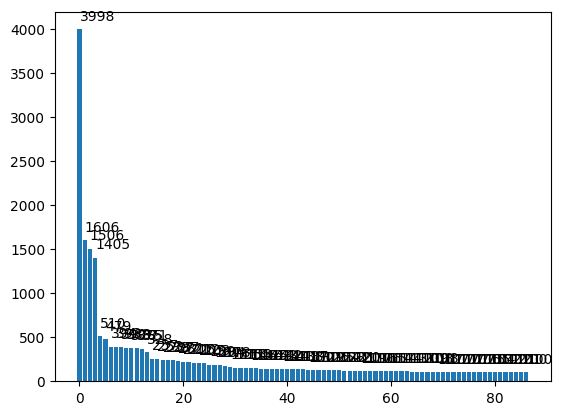

In [34]:
# Distribution
import matplotlib.pyplot as plt
import pandas as pd
hierarchical_clusters_chart = pd.DataFrame(clusters).transpose()
hierarchical_clusters_chart = hierarchical_clusters_chart.count(axis=0)
plt.bar(x=hierarchical_clusters_chart.index,height=hierarchical_clusters_chart.values)
for i in range(hierarchical_clusters_chart.shape[0]):
    plt.text(hierarchical_clusters_chart.index[i], hierarchical_clusters_chart.values[i] + 100, str(round(hierarchical_clusters_chart.values[i], 2)), fontsize=10)
plt.show();


In [37]:
# Print for all clusters the top_k and bottom top_k elements
top_k=10
for i, cluster in enumerate(clusters):
    print("\n\nCluster {}, #{} Elements ".format(i + 1, len(cluster)), '\n------')
    for sentence_id in cluster[0:top_k]:
        print("\t", dataset.sentences_df['sentence'].iloc[sentence_id])
    print("\t", "...")
    for sentence_id in cluster[-top_k:]:
        print("\t", dataset.sentences_df['sentence'].iloc[sentence_id])



Cluster 1, #3998 Elements  
------
	 Je voulais seulement un bordereau d’envoi pour renvoyer la paire et un remboursement impossible de me faire entendre les frais doivent être de ma poche... le service client quant à lui ne comprend toujours pas mon soucis et me demande encore si j’ai reçue ma paire .. de plus mon commentaire sur cdiscount n’a pas était accepté .. bref catastrophique !
	 08), je reçois un mail me disant qu'ils sont désolés car pas en mesure d'honorer la livraison et qu'ils enverraient mon colis plus tard... et toujours pas moyen de rentrer en contact avec eux... donc je ne sait pas si je verrai arriver mon colis un jour, mais en attendant méfiez vous de Cdiscount ils vous appâtent facilement, encaissent facilement votre argent (pas de remboursement, juste bon achats souvent non valides)  mais vous n’êtes vraiment pas sur de voir arriver vos colis.
	 Ils me répondent qu'ils ne savent pas pourquoi le colis leur a été renvoyé et me propose un remboursement que je refus

## k-means

In [ ]:
from sklearn.cluster import KMeans
num_clusters = 10
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings.cpu().numpy())


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


KMeans(n_clusters=10)

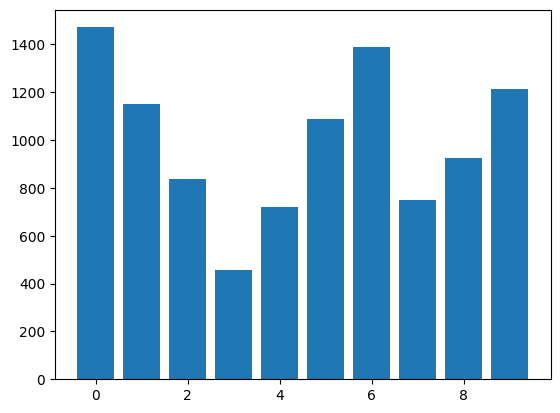

In [ ]:
# distribution
km_cluster_assignment = clustering_model.labels_
km_cluster_assignment = pd.DataFrame(km_cluster_assignment)
km_cluster_assignment = km_cluster_assignment.rename(columns={0: "labels"})
km_cluster_assignment = km_cluster_assignment.value_counts()
km_cluster_assignment = km_cluster_assignment.reset_index(drop=False)
plt.bar(x=km_cluster_assignment["labels"], height=km_cluster_assignment["count"])
plt.show();


In [ ]:
# Print for all clusters the top_k and bottom top_k elements
top_k=10

km_clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(clustering_model.labels_):
    km_clustered_sentences[cluster_id].append(sentence_id)

for i, cluster in enumerate(km_clustered_sentences):
    print("\nCluster {}, #{} Elements ".format(i + 1, len(cluster)))
    for sentence_id in cluster[0:top_k]:
        print("\t", dataset.sentences_df['sentence'].iloc[sentence_id])
    print("\t", "...")
    for sentence_id in cluster[-top_k:]:
        print("\t", dataset.sentences_df['sentence'].iloc[sentence_id])


Cluster 1, #1472 Elements 
	 Très mauvais service, plus de 600 € dépensés, livraison promise hier et commande encore pas traitée !
	 Trop de frais pour l'expédition.
	 Vendredi dernier on me dit que j'aurai eu mon remboursement dans 72h.
	 Ne vaut même pas 1 étoile... Prélèvement de 29 euros en mars 2020.
	 On t'arnaque avec un produit cher qui s’arrêtera de fonctionner dans quelques mois, ensuite oublies la garantie par-ce que ils vont juste s'arranger entre eux pour limiter leurs dégâts et sans doute c'est le client qui paie le prix cher.
	 J'ai effectué un paiement en 4x fois sans frais.
	 J'ai donc payé un objet qu'un illustre inconnu a reçu à ma place gratuitement et Cdiscount ne me rembourse pas et reste muet à mes réclamations.
	 je vais m'empresser d'utiliser ces 2 euros de bon et racheter à la Fnac qui vient de m'arnaquer d'un livre à 12 euros et de 2 appels téléphoniques SURTAXE de 30 min à 15 Euros-C'est "du foutage de g...."???
	 Y’a quelques semaines j’ai mis dans mon pan

# Topic modelling

In [ ]:
# BERT Topics and all ? --> if the sentence embeddings are not great, what's the point ?

# other sentence transformers/embeddings and finetuning ?
- Doc2vec ?
- Universal Sentence Encoder ?

https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/

# supervised and finetuning
- finetuning to the task ?

